In [1]:
import importlib
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter


%matplotlib inline

import cmocean
from glob import glob
import os

from datetime import timedelta, datetime
from datetime import timedelta as delta

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import pop_tools

import PyCO2SYS as pyco2

import multiprocessing

import util
import time
from scipy.spatial import ConvexHull, Delaunay
from scipy.optimize import curve_fit

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

import dask
from dask import delayed

In [2]:
grid = pop_tools.get_grid('POP_gx1v7')[['TAREA', 'KMT', 'TLAT', 'TLONG', 'REGION_MASK']]
tlong = grid.TLONG.values
tlat = grid.TLAT.values

In [3]:
path = '.'

In [5]:
Pacific_polygon_masks = xr.open_dataset(f'{path}/pacific_polygon_masks.nc')
Atlantic_polygon_masks = xr.open_dataset(f'{path}/atlantic_polygon_masks.nc')
South_polygon_masks = xr.open_dataset(f'{path}/south_polygon_masks.nc')
Southern_Ocean_polygon_masks = xr.open_dataset(f'{path}/southern_ocean_polygon_masks.nc')

all_region_masks = [Atlantic_polygon_masks, Pacific_polygon_masks, South_polygon_masks, Southern_Ocean_polygon_masks]

In [6]:
all_curves = xr.open_dataset('./all_curves_global.nc')

# Get maps for OAE efficiency at year 15

In [7]:
regs = ['Atlantic', 'Pacific', 'South', 'Southern_Ocean']
num_polys = [150, 200, 300, 40]

In [19]:
def get_map_OAE_efficiency():
    
    '''
    Generate maps of max pH change in each polygon.
    '''

    x,y = tlong.shape
    whole_eff = np.zeros((4, 180, x, y)) # store 4 seasons of map view

    for r, n, masks in zip(regs, num_polys, all_region_masks):
        masks = masks.mask.values

        for p in range(n):  # number of polygons
            print(r, p)
            mask = masks[p]

            for s in range(4):  # 4 seasons

                

                # for example, OAE_efficiency, length = 189
                list_values = all_curves.sel(region = r).isel(polygon=p, season=s).OAE_efficiency.values
                list_values = list_values[~np.isnan(list_values)] # get rid of nans, now len(list_values) = 180

                index = np.where(mask > 0)
                
                for t in range(180):
                    value = list_values[t] # extract OAE_efficiency at a time point
                    
                    eff = mask * value
                    
                    whole_eff[s, t, :, :][index] = eff[index]

    whole_eff = np.where(whole_eff == 0, np.nan, whole_eff)  
    
    # form a dataset
    whole_eff_ds = xr.Dataset(

        data_vars = {
            'OAE_efficiency': (["season", "N_month", "nlat", "nlon"], whole_eff),
        },
        coords=dict(
            season = (["season"], all_curves.season.values),
            N_month = (["N_month"], np.arange(0,180,1)),
            TLONG=(["nlat", "nlon"], tlong),
            TLAT=(["nlat", "nlon"], tlat),
        ),
    )
    
    return whole_eff_ds

In [20]:
%%time
whole_ds = get_map_OAE_efficiency()    


Atlantic 0
Atlantic 1
Atlantic 2
Atlantic 3
Atlantic 4
Atlantic 5
Atlantic 6
Atlantic 7
Atlantic 8
Atlantic 9
Atlantic 10
Atlantic 11
Atlantic 12
Atlantic 13
Atlantic 14
Atlantic 15
Atlantic 16
Atlantic 17
Atlantic 18
Atlantic 19
Atlantic 20
Atlantic 21
Atlantic 22
Atlantic 23
Atlantic 24
Atlantic 25
Atlantic 26
Atlantic 27
Atlantic 28
Atlantic 29
Atlantic 30
Atlantic 31
Atlantic 32
Atlantic 33
Atlantic 34
Atlantic 35
Atlantic 36
Atlantic 37
Atlantic 38
Atlantic 39
Atlantic 40
Atlantic 41
Atlantic 42
Atlantic 43
Atlantic 44
Atlantic 45
Atlantic 46
Atlantic 47
Atlantic 48
Atlantic 49
Atlantic 50
Atlantic 51
Atlantic 52
Atlantic 53
Atlantic 54
Atlantic 55
Atlantic 56
Atlantic 57
Atlantic 58
Atlantic 59
Atlantic 60
Atlantic 61
Atlantic 62
Atlantic 63
Atlantic 64
Atlantic 65
Atlantic 66
Atlantic 67
Atlantic 68
Atlantic 69
Atlantic 70
Atlantic 71
Atlantic 72
Atlantic 73
Atlantic 74
Atlantic 75
Atlantic 76
Atlantic 77
Atlantic 78
Atlantic 79
Atlantic 80
Atlantic 81
Atlantic 82
Atlantic 83
At

In [27]:
#whole_ds.to_netcdf(f'./OAE_efficiency_maps_alltime.nc')

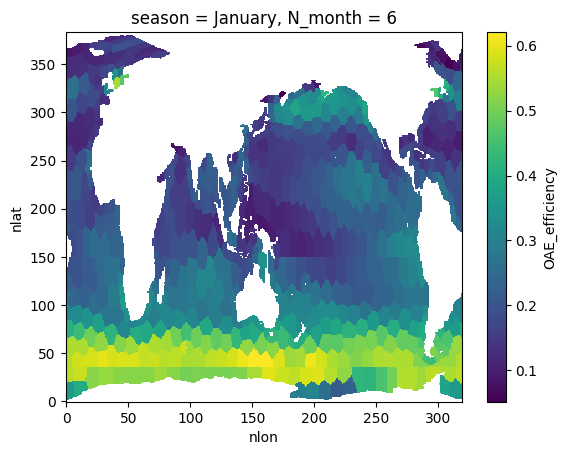

In [26]:
whole_ds.OAE_efficiency.isel(season=0, N_month=6).plot()

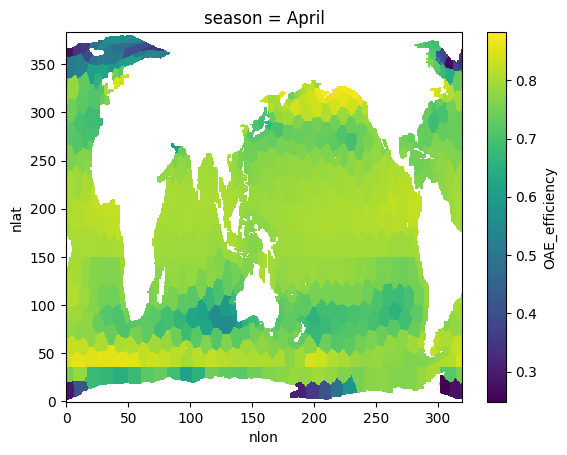

In [11]:
whole_ds.OAE_efficiency.isel(season=1).plot()